In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import io
import base64
import random

import gym
from gym import wrappers
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch

from lib import get_network
from lib.agent import DQN
from lib.logging import Logger
from lib.rollout import ReplayBuffer

from matplotlib import animation
from IPython.display import display

plt.style.use('seaborn')

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

### In this assignment you are going to:
* implement DQN and doubleDQN
* use them on CartPole, LunarLander and (Optionally) BreakOut environments

### We use PyTorch for neural networks. If you are new to PyTorch see tutorials:
https://pytorch.org/tutorials/ <br>
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

# CartPole

First, let's take a closer look at the environment.

In [3]:
def make_env(name, seed=None, monitor=False):
    env = gym.make(name)
    if monitor:
        env = wrappers.Monitor(env, "./gym-results", force=True)
    if seed:
        env.seed(seed)
    return env

In [4]:
def get_html_video_string(infix):
    video = io.open(
        f'./gym-results/openaigym.video.{infix}.video000000.mp4',
        'r+b').read()
    encoded = base64.b64encode(video)
    dec_str = encoded.decode('ascii')
    src_tag = f'<source src="data:video/mp4;base64,{dec_str}" type="video/mp4" /></video>'
    html = f'<video width="360" height="auto" alt="test" controls>{src_tag}</video>'
    return html

In [5]:
SEED = 0xCEEEEEEB
random.seed(SEED)
torch.manual_seed(SEED)

np.random.seed(SEED)

In [6]:
log_root = Path("results")
log_root.mkdir(exist_ok=True)

The next cell will embed a video of random policy playing CartPole-v1

In [7]:
env = make_env("CartPole-v0", monitor=True)
env.reset()
frames = []
for t in range(1000):
    action = env.action_space.sample()
    frame = env.render()
    frames.append(frame)
    if env.step(action)[2]:
        break
env.render(close=True)
display_frames_as_gif(frames)        


DependencyNotInstalled: Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

## Training loop
Here's the definition of a function that implements training loop. We'll get through its elements soon.
Although, note that we use a warmup techinque to fill the buffer in the beginning of a training procedure.

The loop consists of:
* Picking an action using the policy:
$$a = \text{argmax}_a Q(s, a)$$
* Sending the action to environment (`step`)
* Sampling N examples from the ReplayBuffer:
$$ (s_i, a_i, s^\prime_i, r_i)_{i=1,..,N} $$
* Updating Q-network by minimizing the loss:
$$y = r_i + \gamma \text{max}_a Q_{target}(s^{\prime}_i, a) \mathbb{1}\{s^{\prime}_i \text{ is not terminal}\} $$

$$L_i = \text{Loss}(Q(s_i, a_i), y)$$
$$L = \frac{1}{N} \sum_i L_i \rightarrow min,$$
where $\text{Loss}$ is $L_2$ loss or Huber loss
* Updating target network every `target_update_every` iteration:
$$\theta^\prime \leftarrow \theta \tau + \theta^\prime (1 - \tau)$$
where $\theta^\prime$ - paremeters of $Q_{target}$ network, <br>
$\theta$ - paremeters of $Q$ network,<br>
$\tau \in [0, 1]$

Note, that we also use a logger that writes training info to `CSV` file, `TensorBoard` and `stdout`. We use `CSV` and `stdout` throughout the notebook, but you can use TB for convenience.

#### Task 0: Implement ReplayBuffer from `lib/rollout.py`

In [90]:
def train(
    agent,
    env,
    *,
    log_dir,
    prefix,
    buffer_size,
    n_steps,
    warmup_steps,
    target_update_every,
    log_every,
    save_every,
    modify_reward = False
):
    """Training loop procedure.
    
    Arguments:
        agent: DQN object.
        env: Gym environment.
        log_dir: PathLib path to logging dir.
        prefix: Prefix for the experiment.
        buffer_size: Maximum capacity of the replay buffer.
        n_steps: Total number of training iterations.
        warmup_steps: Number of first iterations that employ random policy.
        target_update_every: Number of iterations between target network updates.
        log_every: Log frequency
        save_every: Save frequency
        
    Returns agent after training.
    """
    
    logger = Logger(log_dir, prefix)
    episode_reward = []
    memory = ReplayBuffer(buffer_size)
    
    obs_cur = env.reset()
    for i in range(n_steps + 1):
        
        if i > warmup_steps:
            obs = torch.FloatTensor(obs_cur).unsqueeze(0)
            act = agent.pick_action(obs)
            #print("agent picked!")
        else:
            act = env.action_space.sample()
            
        #print(act)
        obs_prev = obs_cur
        obs_cur, rew, done, info = env.step(act)
        rew += 10 * abs(obs_cur[1]) if modify_reward else 0
        #rew += 50 * (abs(obs_cur[1]) - abs(obs_prev[1]))
        episode_reward.append(rew)

        memory.push(obs_prev, act, obs_cur, rew, done)

        if done:
            rew = np.sum(episode_reward)
            episode_reward = []
            logger.log_arr_kv("reward/reward", rew)
            obs_cur = env.reset()

        if i > warmup_steps:

            loss, q, q_est = agent.update_value(memory)
            logger.log_arr_kv("loss/bellman_error_t", loss)
            logger.log_arr_kv("misc/q_t", q)
            logger.log_arr_kv("misc/q_est_t", q_est)

            if i % target_update_every == 0:
                agent.update_target()

            if i % log_every == 0:
                logger.reduce_arr_kv("reward/reward", "reward/reward_mean", np.mean)
                logger.reduce_arr_kv("reward/reward", "reward/reward_max", np.max)
                logger.reduce_arr_kv("reward/reward", "reward/reward_min", np.min)
                logger.reduce_arr_kv("reward/reward", "reward/reward_std", np.std)
                logger.reduce_arr_kv("loss/bellman_error_t", "loss/bellman_error", np.mean)
                logger.reduce_arr_kv("misc/q_t", "misc/q", np.mean)
                logger.reduce_arr_kv("misc/q_est_t", "misc/q_est", np.mean)
                logger.log_kv("misc/epsilon", agent.eps)
                logger.log_kv("misc/timestep", i)
                logger.write_logs(skip_arrs=True)

            if i % save_every == 0:
                num = i // save_every + 1
                save_dir = log_dir / "checkpoints"
                save_dir.mkdir(exist_ok=True)
                agent.save_to(save_dir, prefix=hex(num)[2:].upper())

        agent.update_eps()
    return agent

# Implementation
#### Task 1: Implement MLP network in `lib/network.py`
#### Task 2: Implement DQN in `lib/agent.py`

Now, run the next two cells. You should obtain the highest (500) reward in less than 100000 steps

Note! You can try to use small `target_update_every`. E.g. value of 1 corresponds to fitted Q-iteration. The expected outcome is unstable or even divergent behaviour

In [9]:
env = make_env("CartPole-v0", SEED)
print(gym.make("CartPole-v0"))

value_network = get_network("mlp")(
    env.observation_space.shape[0],
    64,
    env.action_space.n,
)

agent = DQN(
    value_network,
    env.action_space,
    eps=.2,
    eps_decay=(.2 - .02) / 10**5,
    batch_size=32,
    learning_rate=5e-4,
    discount_factor=.99
)

<TimeLimit<CartPoleEnv<CartPole-v0>>>


In [10]:
agent = train(
    agent,
    gym.make("CartPole-v1"),
    log_dir=log_root / "cartpole-v1",
    prefix="_dqn",
    
    buffer_size=5 * 10**4,
    n_steps=10**5,
    warmup_steps=1000,
    target_update_every=500,
    log_every=500,
    save_every=1000,
)

/Users/vamdemon/anaconda3/envs/gym/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vamdemon/anaconda3/envs/gym/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vamdemon/anaconda3/envs/gym/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vamdemon/anaconda3/envs/gym/lib/python3

---------------------------------
| reward/reward_mean | 25.965   |
| reward/reward_max  | 76       |
| reward/reward_min  | 9        |
| reward/reward_std  | 16.002   |
| loss/bellman_error | 0.48734  |
| misc/q             | 0.37476  |
| misc/q_est         | 1.3584   |
| misc/epsilon       | 0.1973   |
| misc/timestep      | 1500     |
---------------------------------
---------------------------------
| reward/reward_mean | 22.522   |
| reward/reward_max  | 61       |
| reward/reward_min  | 9        |
| reward/reward_std  | 15.033   |
| loss/bellman_error | 0.4567   |
| misc/q             | 1.1342   |
| misc/q_est         | 2.0737   |
| misc/epsilon       | 0.1964   |
| misc/timestep      | 2000     |
---------------------------------
---------------------------------
| reward/reward_mean | 27.667   |
| reward/reward_max  | 57       |
| reward/reward_min  | 10       |
| reward/reward_std  | 13.153   |
| loss/bellman_error | 0.43271  |
| misc/q             | 1.931    |
| misc/q_est  

---------------------------------
| reward/reward_mean | 133      |
| reward/reward_max  | 147      |
| reward/reward_min  | 105      |
| reward/reward_std  | 17.146   |
| loss/bellman_error | 0.33057  |
| misc/q             | 10.756   |
| misc/q_est         | 11.415   |
| misc/epsilon       | 0.1775   |
| misc/timestep      | 12500    |
---------------------------------
---------------------------------
| reward/reward_mean | 143      |
| reward/reward_max  | 299      |
| reward/reward_min  | 61       |
| reward/reward_std  | 110.36   |
| loss/bellman_error | 0.33216  |
| misc/q             | 11.307   |
| misc/q_est         | 11.972   |
| misc/epsilon       | 0.1766   |
| misc/timestep      | 13000    |
---------------------------------
---------------------------------
| reward/reward_mean | 190      |
| reward/reward_max  | 276      |
| reward/reward_min  | 131      |
| reward/reward_std  | 62.199   |
| loss/bellman_error | 0.33443  |
| misc/q             | 11.679   |
| misc/q_est  

---------------------------------
| reward/reward_mean | 230      |
| reward/reward_max  | 293      |
| reward/reward_min  | 167      |
| reward/reward_std  | 63       |
| loss/bellman_error | 0.288    |
| misc/q             | 22.023   |
| misc/q_est         | 22.556   |
| misc/epsilon       | 0.1577   |
| misc/timestep      | 23500    |
---------------------------------
---------------------------------
| reward/reward_mean | 222.5    |
| reward/reward_max  | 260      |
| reward/reward_min  | 185      |
| reward/reward_std  | 37.5     |
| loss/bellman_error | 0.28246  |
| misc/q             | 23.045   |
| misc/q_est         | 23.576   |
| misc/epsilon       | 0.1568   |
| misc/timestep      | 24000    |
---------------------------------
---------------------------------
| reward/reward_mean | 241      |
| reward/reward_max  | 262      |
| reward/reward_min  | 220      |
| reward/reward_std  | 21       |
| loss/bellman_error | 0.2914   |
| misc/q             | 23.501   |
| misc/q_est  

---------------------------------
| reward/reward_mean | 214      |
| reward/reward_max  | 257      |
| reward/reward_min  | 177      |
| reward/reward_std  | 32.934   |
| loss/bellman_error | 0.1958   |
| misc/q             | 35.77    |
| misc/q_est         | 36.15    |
| misc/epsilon       | 0.1379   |
| misc/timestep      | 34500    |
---------------------------------
---------------------------------
| reward/reward_mean | 259      |
| reward/reward_max  | 264      |
| reward/reward_min  | 254      |
| reward/reward_std  | 5        |
| loss/bellman_error | 0.20915  |
| misc/q             | 37.353   |
| misc/q_est         | 37.708   |
| misc/epsilon       | 0.137    |
| misc/timestep      | 35000    |
---------------------------------
---------------------------------
| reward/reward_mean | 320      |
| reward/reward_max  | 320      |
| reward/reward_min  | 320      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.21681  |
| misc/q             | 37.468   |
| misc/q_est  

---------------------------------
| reward/reward_mean | 283      |
| reward/reward_max  | 297      |
| reward/reward_min  | 269      |
| reward/reward_std  | 14       |
| loss/bellman_error | 0.18109  |
| misc/q             | 46.133   |
| misc/q_est         | 46.382   |
| misc/epsilon       | 0.1181   |
| misc/timestep      | 45500    |
---------------------------------
---------------------------------
| reward/reward_mean | 281.5    |
| reward/reward_max  | 290      |
| reward/reward_min  | 273      |
| reward/reward_std  | 8.5      |
| loss/bellman_error | 0.16891  |
| misc/q             | 45.924   |
| misc/q_est         | 46.181   |
| misc/epsilon       | 0.1172   |
| misc/timestep      | 46000    |
---------------------------------
---------------------------------
| reward/reward_mean | 370      |
| reward/reward_max  | 370      |
| reward/reward_min  | 370      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.18795  |
| misc/q             | 46.063   |
| misc/q_est  

---------------------------------
| reward/reward_mean | 500      |
| reward/reward_max  | 500      |
| reward/reward_min  | 500      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.090383 |
| misc/q             | 61.114   |
| misc/q_est         | 61.239   |
| misc/epsilon       | 0.0983   |
| misc/timestep      | 56500    |
---------------------------------
---------------------------------
| reward/reward_mean | 364      |
| reward/reward_max  | 375      |
| reward/reward_min  | 353      |
| reward/reward_std  | 11       |
| loss/bellman_error | 0.093313 |
| misc/q             | 60.744   |
| misc/q_est         | 60.867   |
| misc/epsilon       | 0.0974   |
| misc/timestep      | 57000    |
---------------------------------
---------------------------------
| reward/reward_mean | 500      |
| reward/reward_max  | 500      |
| reward/reward_min  | 500      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.087326 |
| misc/q             | 61.34    |
| misc/q_est  

---------------------------------
| reward/reward_mean | 500      |
| reward/reward_max  | 500      |
| reward/reward_min  | 500      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.075951 |
| misc/q             | 69.395   |
| misc/q_est         | 69.473   |
| misc/epsilon       | 0.0785   |
| misc/timestep      | 67500    |
---------------------------------
---------------------------------
| reward/reward_mean | 500      |
| reward/reward_max  | 500      |
| reward/reward_min  | 500      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.086231 |
| misc/q             | 69.828   |
| misc/q_est         | 69.895   |
| misc/epsilon       | 0.0776   |
| misc/timestep      | 68000    |
---------------------------------
---------------------------------
| reward/reward_mean | 499      |
| reward/reward_max  | 499      |
| reward/reward_min  | 499      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.083626 |
| misc/q             | 68.489   |
| misc/q_est  

---------------------------------
| reward/reward_mean | 500      |
| reward/reward_max  | 500      |
| reward/reward_min  | 500      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.090709 |
| misc/q             | 72.303   |
| misc/q_est         | 72.374   |
| misc/epsilon       | 0.0587   |
| misc/timestep      | 78500    |
---------------------------------
---------------------------------
| reward/reward_mean | 500      |
| reward/reward_max  | 500      |
| reward/reward_min  | 500      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.06307  |
| misc/q             | 75.079   |
| misc/q_est         | 75.146   |
| misc/epsilon       | 0.0578   |
| misc/timestep      | 79000    |
---------------------------------
---------------------------------
| reward/reward_mean | 500      |
| reward/reward_max  | 500      |
| reward/reward_min  | 500      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.095527 |
| misc/q             | 74.132   |
| misc/q_est  

---------------------------------
| reward/reward_mean | 500      |
| reward/reward_max  | 500      |
| reward/reward_min  | 500      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.10643  |
| misc/q             | 75.839   |
| misc/q_est         | 75.901   |
| misc/epsilon       | 0.0389   |
| misc/timestep      | 89500    |
---------------------------------
---------------------------------
| reward/reward_mean | 500      |
| reward/reward_max  | 500      |
| reward/reward_min  | 500      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.13054  |
| misc/q             | 75.409   |
| misc/q_est         | 75.447   |
| misc/epsilon       | 0.038    |
| misc/timestep      | 90000    |
---------------------------------
---------------------------------
| reward/reward_mean | 500      |
| reward/reward_max  | 500      |
| reward/reward_min  | 500      |
| reward/reward_std  | 0        |
| loss/bellman_error | 0.1282   |
| misc/q             | 74.14    |
| misc/q_est  

Now, let's take a look at our learned policy in action:

In [16]:
env = make_env("CartPole-v1", monitor=True)
obs = env.reset()
while True:
    obs = torch.FloatTensor(obs).unsqueeze(0)
    act = agent.pick_action(obs, force_greedy=True)
    obs, rew, done, info = env.step(act)
    if done: break
env.close()

#HTML(data=get_html_video_string(env.file_infix))

DependencyNotInstalled: Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

In [78]:
def plot_progress(data, name=None):
    name = name or "Mean reward"
    plt.plot(data['misc/timestep'], data['reward/reward_mean'], label=name)
    lower = np.array(data['reward/reward_mean'] - data['reward/reward_std']).clip(-1e5, +1e5)
    upper = np.array(data['reward/reward_mean'] + data['reward/reward_std']).clip(-1e5, +1e5)
    examples = np.array(data['misc/timestep'])
    plt.fill_between(list(examples), list(lower), list(upper), color='blue', alpha=0.1)
    plt.legend(loc='best')
    plt.xlabel("Timestep")
    plt.ylabel("Reward")

The following cell plots a mean reward against training iterations. Note, that the agent may sometimes degrade its performance.

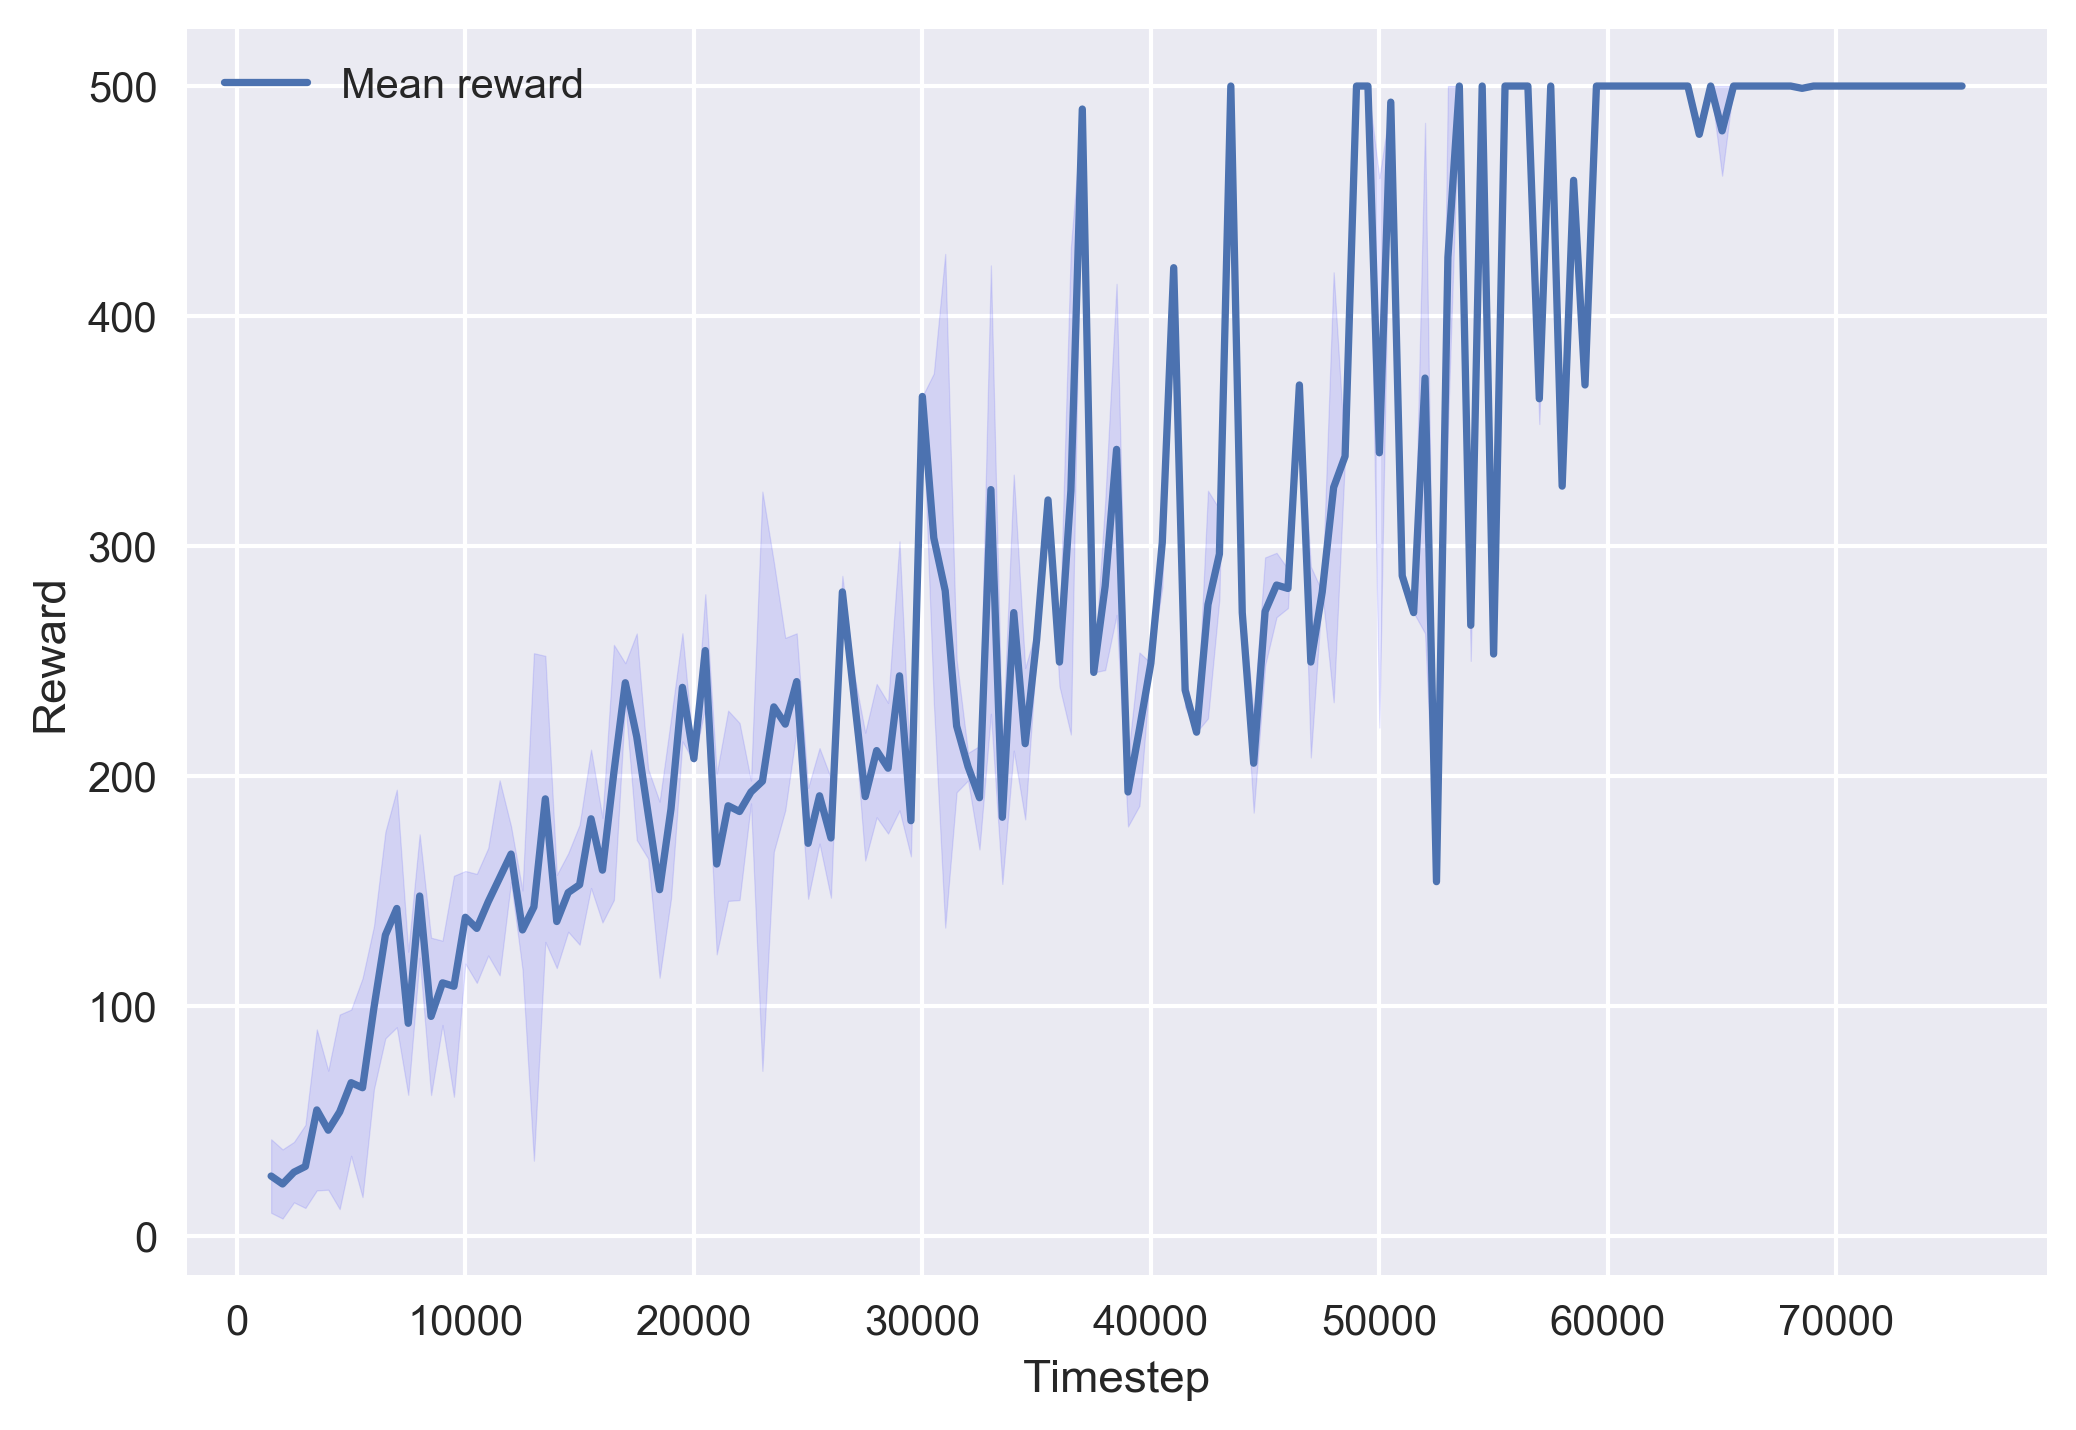

In [13]:
plt.figure(dpi=300)
df = pd.read_csv(str(log_root / "cartpole-v1" / "logs_dqn.csv"), sep=";")
plot_progress(df)

# LunarLander

Okay, now that we're done with very simple CartPole environment, let's move to something more complicated. 

LunarLander is a simulation game where a player has to control the capsule and land it on the zone marked with flags. If an agent achieves more than 200 scores, the environment is said to be solved.

##### First, you should install Box2D support in Gym: 

In [14]:
!pip install 'gym[box2d]'

##### The random policy quickly fails the task:

In [7]:
#I faced an issue with an installing Box2D to Python 3.8, therefore I have chosen another environment 
#to work with.
env = make_env("MountainCar-v0", monitor=True)
env.reset()
while True:
    action = env.action_space.sample()
    if env.step(action)[2]: break
env.close()

HTML(data=get_html_video_string(env.file_infix))

DependencyNotInstalled: Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

#### Task 3: Play a bit with hyperparameters. You have to gain some intuition about what each of them does. You have to achieve mean score of 200 in ~200 000 iterations

In [96]:
env = make_env("MountainCar-v0", SEED)
value_network = get_network("mlp")(
    env.observation_space.shape[0],
    32,
    env.action_space.n)

agent = DQN(
    value_network,
    env.action_space,
    eps=.1,
    eps_decay=(.1 - .01) / 10**5,
    batch_size=64,
    learning_rate=5e-4,
    discount_factor=0.9
)

In [97]:
agent = train(
    agent,
    env,
    log_dir=log_root / "MountainCar-v0_single",
    prefix="_dqn",
    buffer_size=5 * 10**4,
    n_steps=10**5,
    warmup_steps=1000,
    target_update_every=500,
    log_every=500,
    save_every=1000,
    modify_reward=True,
)

---------------------------------
| reward/reward_mean | -187.21  |
| reward/reward_max  | -179.33  |
| reward/reward_min  | -193.14  |
| reward/reward_std  | 5.4486   |
| loss/bellman_error | 0.18553  |
| misc/q             | -0.97187 |
| misc/q_est         | -1.4166  |
| misc/epsilon       | 0.09865  |
| misc/timestep      | 1500     |
---------------------------------
---------------------------------
| reward/reward_mean | -185.44  |
| reward/reward_max  | -178.41  |
| reward/reward_min  | -191.64  |
| reward/reward_std  | 5.4329   |
| loss/bellman_error | 0.048626 |
| misc/q             | -7.3482  |
| misc/q_est         | -7.4336  |
| misc/epsilon       | 0.0982   |
| misc/timestep      | 2000     |
---------------------------------
---------------------------------
| reward/reward_mean | -186.57  |
| reward/reward_max  | -184.57  |
| reward/reward_min  | -188.56  |
| reward/reward_std  | 1.996    |
| loss/bellman_error | 0.039314 |
| misc/q             | -8.4571  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -189.57  |
| reward/reward_max  | -187.52  |
| reward/reward_min  | -191.62  |
| reward/reward_std  | 2.0517   |
| loss/bellman_error | 0.033725 |
| misc/q             | -7.7596  |
| misc/q_est         | -7.7755  |
| misc/epsilon       | 0.08875  |
| misc/timestep      | 12500    |
---------------------------------
---------------------------------
| reward/reward_mean | -188.51  |
| reward/reward_max  | -183.13  |
| reward/reward_min  | -197.64  |
| reward/reward_std  | 6.4904   |
| loss/bellman_error | 0.034821 |
| misc/q             | -7.929   |
| misc/q_est         | -7.9427  |
| misc/epsilon       | 0.0883   |
| misc/timestep      | 13000    |
---------------------------------
---------------------------------
| reward/reward_mean | -186.36  |
| reward/reward_max  | -180.27  |
| reward/reward_min  | -192.46  |
| reward/reward_std  | 6.0957   |
| loss/bellman_error | 0.035472 |
| misc/q             | -7.8322  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -188.54  |
| reward/reward_max  | -184.8   |
| reward/reward_min  | -192.28  |
| reward/reward_std  | 3.7429   |
| loss/bellman_error | 0.041062 |
| misc/q             | -8.4176  |
| misc/q_est         | -8.43    |
| misc/epsilon       | 0.07885  |
| misc/timestep      | 23500    |
---------------------------------
---------------------------------
| reward/reward_mean | -189.56  |
| reward/reward_max  | -179.26  |
| reward/reward_min  | -195.22  |
| reward/reward_std  | 7.2938   |
| loss/bellman_error | 0.032602 |
| misc/q             | -8.5997  |
| misc/q_est         | -8.6098  |
| misc/epsilon       | 0.0784   |
| misc/timestep      | 24000    |
---------------------------------
---------------------------------
| reward/reward_mean | -194.49  |
| reward/reward_max  | -192.49  |
| reward/reward_min  | -196.48  |
| reward/reward_std  | 1.9969   |
| loss/bellman_error | 0.037292 |
| misc/q             | -8.5323  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -147.38  |
| reward/reward_max  | -144.55  |
| reward/reward_min  | -150.22  |
| reward/reward_std  | 2.8376   |
| loss/bellman_error | 0.032617 |
| misc/q             | -6.482   |
| misc/q_est         | -6.5069  |
| misc/epsilon       | 0.06895  |
| misc/timestep      | 34500    |
---------------------------------
---------------------------------
| reward/reward_mean | -143.39  |
| reward/reward_max  | -142.45  |
| reward/reward_min  | -145.09  |
| reward/reward_std  | 1.2032   |
| loss/bellman_error | 0.030141 |
| misc/q             | -6.6408  |
| misc/q_est         | -6.664   |
| misc/epsilon       | 0.0685   |
| misc/timestep      | 35000    |
---------------------------------
---------------------------------
| reward/reward_mean | -144.1   |
| reward/reward_max  | -142.64  |
| reward/reward_min  | -145.55  |
| reward/reward_std  | 1.4544   |
| loss/bellman_error | 0.034823 |
| misc/q             | -6.4496  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -146.62  |
| reward/reward_max  | -144.58  |
| reward/reward_min  | -148.65  |
| reward/reward_std  | 2.0378   |
| loss/bellman_error | 0.033535 |
| misc/q             | -6.7364  |
| misc/q_est         | -6.7605  |
| misc/epsilon       | 0.05905  |
| misc/timestep      | 45500    |
---------------------------------
---------------------------------
| reward/reward_mean | -144.07  |
| reward/reward_max  | -142.58  |
| reward/reward_min  | -146.12  |
| reward/reward_std  | 1.4991   |
| loss/bellman_error | 0.034524 |
| misc/q             | -6.7161  |
| misc/q_est         | -6.7426  |
| misc/epsilon       | 0.0586   |
| misc/timestep      | 46000    |
---------------------------------
---------------------------------
| reward/reward_mean | -148.53  |
| reward/reward_max  | -148.09  |
| reward/reward_min  | -148.97  |
| reward/reward_std  | 0.43877  |
| loss/bellman_error | 0.0334   |
| misc/q             | -6.7361  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -105.07  |
| reward/reward_max  | -101.4   |
| reward/reward_min  | -108.35  |
| reward/reward_std  | 2.8508   |
| loss/bellman_error | 0.027884 |
| misc/q             | -6.6537  |
| misc/q_est         | -6.6834  |
| misc/epsilon       | 0.04915  |
| misc/timestep      | 56500    |
---------------------------------
---------------------------------
| reward/reward_mean | -104.73  |
| reward/reward_max  | -100.85  |
| reward/reward_min  | -111.9   |
| reward/reward_std  | 4.298    |
| loss/bellman_error | 0.026387 |
| misc/q             | -6.7127  |
| misc/q_est         | -6.7412  |
| misc/epsilon       | 0.0487   |
| misc/timestep      | 57000    |
---------------------------------
---------------------------------
| reward/reward_mean | -106.94  |
| reward/reward_max  | -105.84  |
| reward/reward_min  | -108.81  |
| reward/reward_std  | 1.3327   |
| loss/bellman_error | 0.025165 |
| misc/q             | -6.7541  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -191.73  |
| reward/reward_max  | -187.7   |
| reward/reward_min  | -196.13  |
| reward/reward_std  | 3.4508   |
| loss/bellman_error | 0.016022 |
| misc/q             | -5.6702  |
| misc/q_est         | -5.6866  |
| misc/epsilon       | 0.03925  |
| misc/timestep      | 67500    |
---------------------------------
---------------------------------
| reward/reward_mean | -194.75  |
| reward/reward_max  | -193.83  |
| reward/reward_min  | -195.67  |
| reward/reward_std  | 0.91927  |
| loss/bellman_error | 0.016709 |
| misc/q             | -5.7432  |
| misc/q_est         | -5.7566  |
| misc/epsilon       | 0.0388   |
| misc/timestep      | 68000    |
---------------------------------
---------------------------------
| reward/reward_mean | -194.87  |
| reward/reward_max  | -192.83  |
| reward/reward_min  | -198.34  |
| reward/reward_std  | 2.4649   |
| loss/bellman_error | 0.017178 |
| misc/q             | -5.7091  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -170.89  |
| reward/reward_max  | -158.09  |
| reward/reward_min  | -192.33  |
| reward/reward_std  | 15.253   |
| loss/bellman_error | 0.01435  |
| misc/q             | -6.1009  |
| misc/q_est         | -6.1165  |
| misc/epsilon       | 0.02935  |
| misc/timestep      | 78500    |
---------------------------------
---------------------------------
| reward/reward_mean | -165     |
| reward/reward_max  | -162.7   |
| reward/reward_min  | -167.3   |
| reward/reward_std  | 2.2981   |
| loss/bellman_error | 0.012927 |
| misc/q             | -6.2087  |
| misc/q_est         | -6.223   |
| misc/epsilon       | 0.0289   |
| misc/timestep      | 79000    |
---------------------------------
---------------------------------
| reward/reward_mean | -173.06  |
| reward/reward_max  | -164.02  |
| reward/reward_min  | -188.55  |
| reward/reward_std  | 11.005   |
| loss/bellman_error | 0.016576 |
| misc/q             | -6.0633  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -95.567  |
| reward/reward_max  | -82.787  |
| reward/reward_min  | -129.94  |
| reward/reward_std  | 19.861   |
| loss/bellman_error | 0.020003 |
| misc/q             | -6.8183  |
| misc/q_est         | -6.8356  |
| misc/epsilon       | 0.01945  |
| misc/timestep      | 89500    |
---------------------------------
---------------------------------
| reward/reward_mean | -92.088  |
| reward/reward_max  | -73.653  |
| reward/reward_min  | -124.76  |
| reward/reward_std  | 19.43    |
| loss/bellman_error | 0.019461 |
| misc/q             | -6.8711  |
| misc/q_est         | -6.8874  |
| misc/epsilon       | 0.019    |
| misc/timestep      | 90000    |
---------------------------------
---------------------------------
| reward/reward_mean | -85.09   |
| reward/reward_max  | -81.995  |
| reward/reward_min  | -88.608  |
| reward/reward_std  | 2.4139   |
| loss/bellman_error | 0.018939 |
| misc/q             | -6.8868  |
| misc/q_est  

In [76]:
env = make_env("MountainCar-v0", monitor=True)
obs = env.reset()
while True:
    obs = torch.FloatTensor(obs).unsqueeze(0)
    act = agent.pick_action(obs, force_greedy=True)
    obs, rew, done, info = env.step(act)
    if done: break
env.close()

HTML(data=get_html_video_string(env.file_infix))

AttributeError: module 'gym.envs.box2d' has no attribute 'LunarLander'

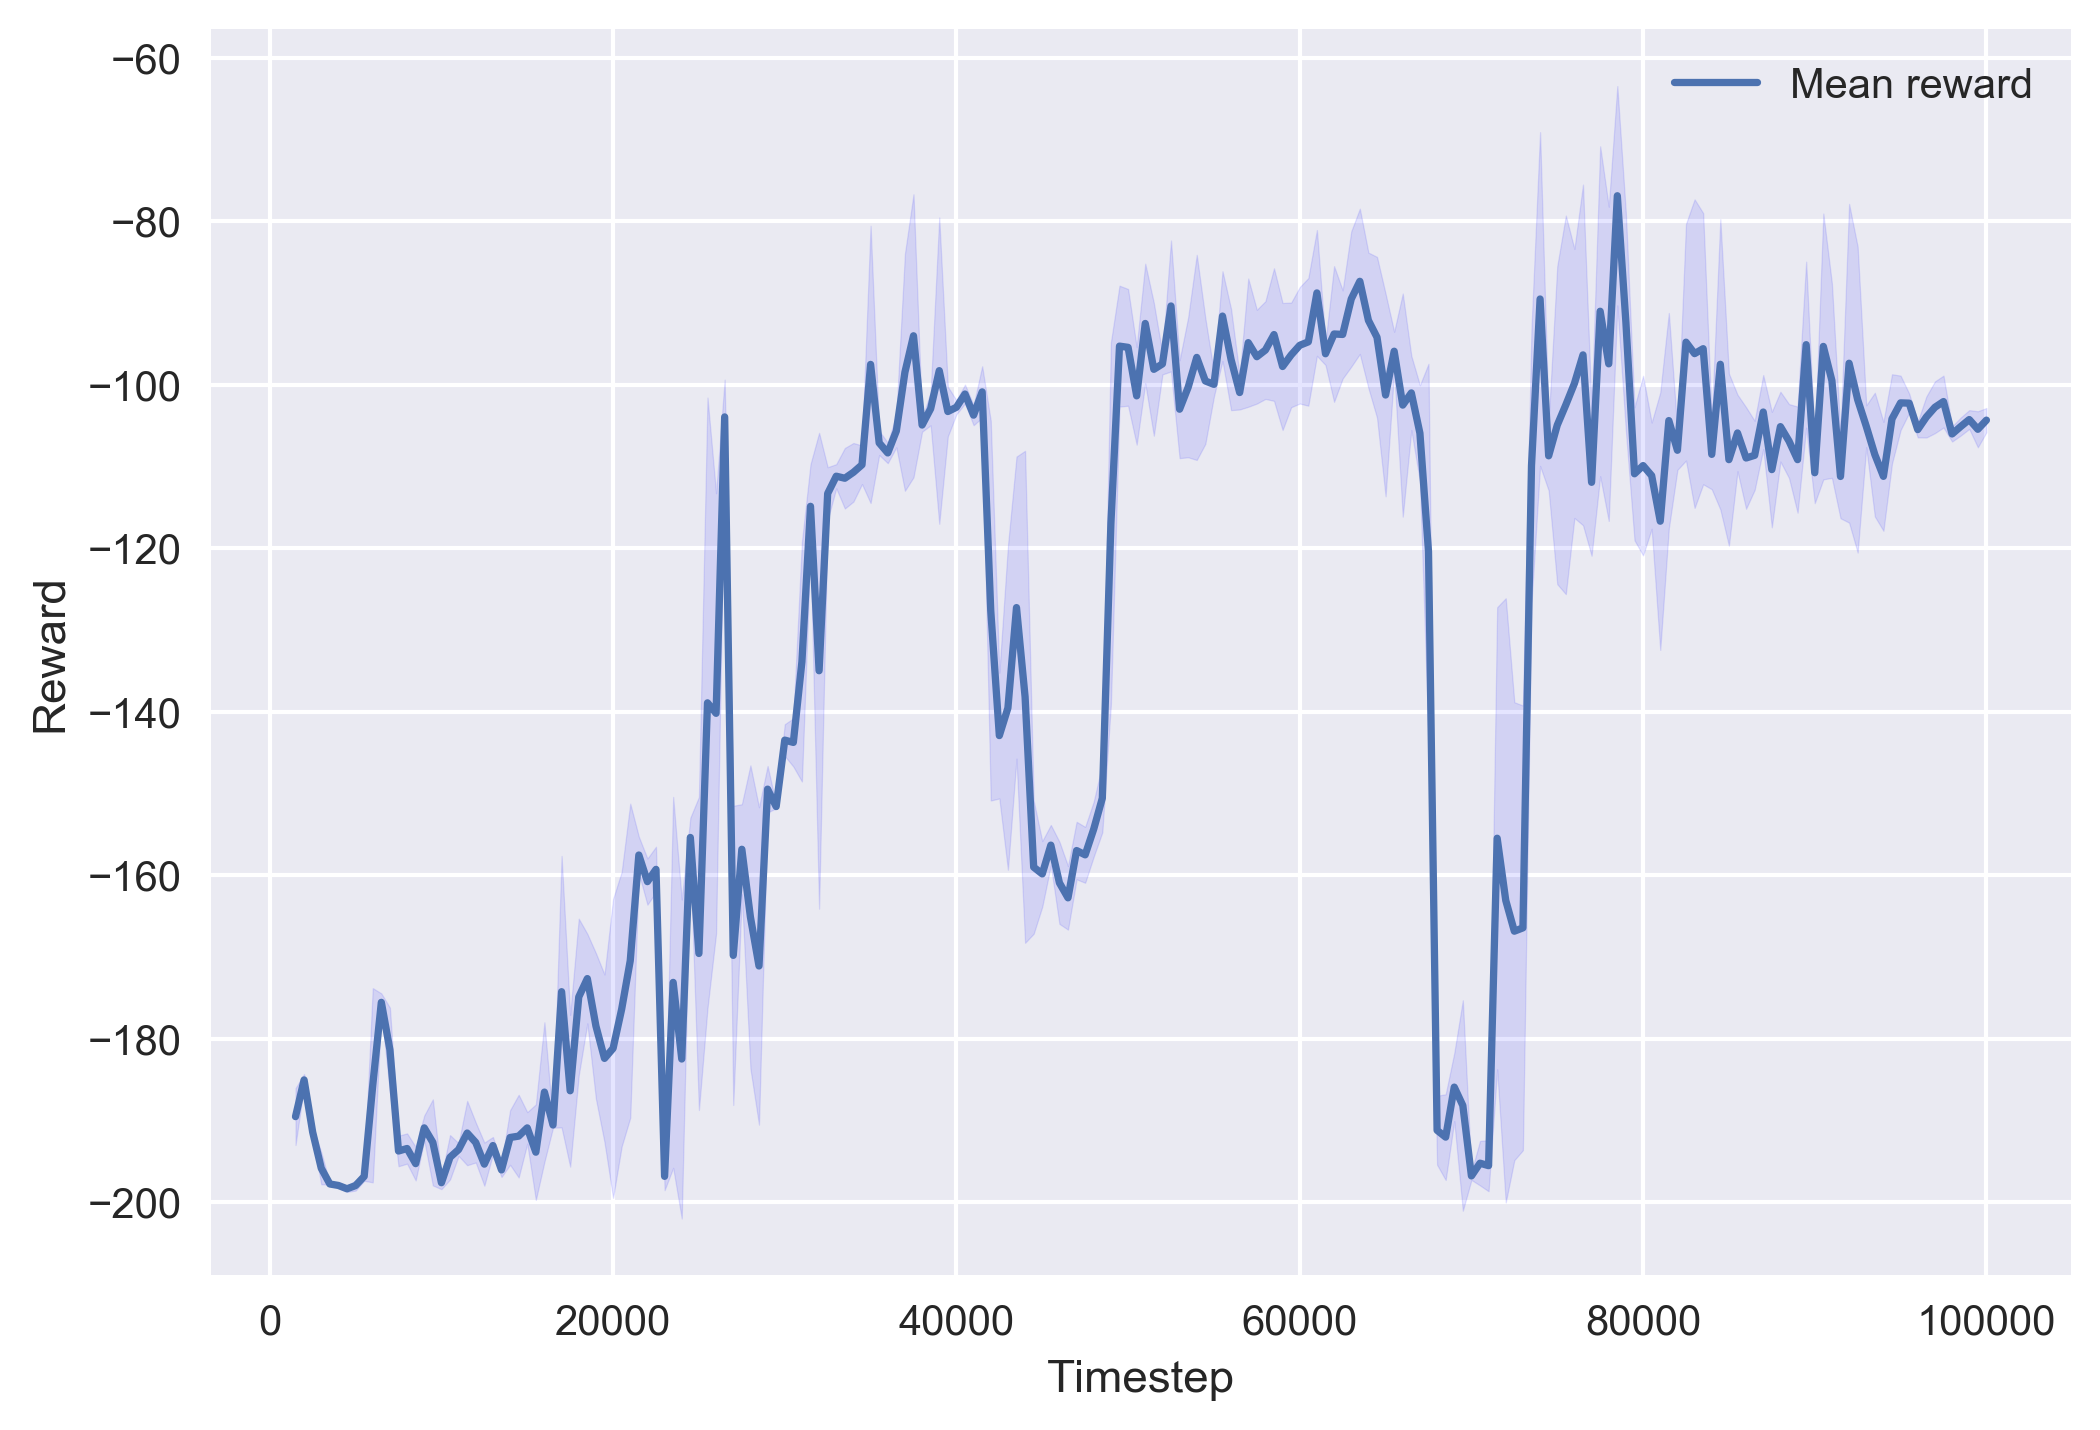

In [92]:
plt.figure(dpi=300)
df = pd.read_csv(str(log_root / "MountainCar-v0_single" / "logs_dqn.csv"), sep=";")
plot_progress(df)

## Double DQN

One of the main drawbacks of vanila DQN is that it overestimates Q-values. More details could be found in the original paper. In a couple of words, we have to estimate an expecation of maximum, not a maximum of expectations as we do in vanila DQN. The trick is to use the second network for the updates (we use target network for this):

$$y = r + \gamma Q_{target}(s^\prime, \text{argmax}_a Q(s^\prime, a) ) \mathbb{1}\{s^{\prime} \text{ is not terminal}\}$$

Compared to 

$$y = r + \gamma Q_{target}(s^\prime, \text{argmax}_a Q_{target}(s^\prime, a) ) \mathbb{1}\{s^{\prime} \text{ is not terminal}\}$$

from vanila DQN. Which is the same as:

$$y = r + \gamma \text{max}_a Q_{target}(s^\prime, a) \mathbb{1}\{s^{\prime} \text{ is not terminal}\}$$

Double Q-learning paper: https://papers.nips.cc/paper/3964-double-q-learning <br>
Double DQN paper: https://arxiv.org/abs/1509.06461

#### Task 4. Implement Double DQN in `lib/agent.py`. 

 Now, let's try it for the LunarLander environment:

In [93]:
env = make_env("MountainCar-v0", SEED)

value_network = get_network("mlp")(
    env.observation_space.shape[0],
    32,
    env.action_space.n)

agent = DQN(
    value_network,
    env.action_space,
    eps=.1,
    eps_decay=(.1 - .01) / 10**5,
    batch_size=64,
    learning_rate=5e-4,
    discount_factor=0.9,
    double=True
)

In [94]:
agent = train(
    agent,
    env,
    log_dir=log_root / "MountainCar-v0",
    prefix="_dqn",
    buffer_size=5 * 10**4,
    n_steps=10**5,
    warmup_steps=1000,
    target_update_every=500,
    log_every=500,
    save_every=1000,
    modify_reward=True,
)

---------------------------------
| reward/reward_mean | -185.47  |
| reward/reward_max  | -168.43  |
| reward/reward_min  | -194.04  |
| reward/reward_std  | 7.8118   |
| loss/bellman_error | 0.071496 |
| misc/q             | -0.69377 |
| misc/q_est         | -0.89563 |
| misc/epsilon       | 0.09865  |
| misc/timestep      | 1500     |
---------------------------------
---------------------------------
| reward/reward_mean | -186.57  |
| reward/reward_max  | -176.6   |
| reward/reward_min  | -191.66  |
| reward/reward_std  | 7.0505   |
| loss/bellman_error | 0.012192 |
| misc/q             | -1.6966  |
| misc/q_est         | -1.7201  |
| misc/epsilon       | 0.0982   |
| misc/timestep      | 2000     |
---------------------------------
---------------------------------
| reward/reward_mean | -190.35  |
| reward/reward_max  | -189.43  |
| reward/reward_min  | -191.27  |
| reward/reward_std  | 0.92002  |
| loss/bellman_error | 0.011633 |
| misc/q             | -2.4621  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -116.92  |
| reward/reward_max  | -98.088  |
| reward/reward_min  | -136.63  |
| reward/reward_std  | 15.747   |
| loss/bellman_error | 0.038226 |
| misc/q             | -7.7071  |
| misc/q_est         | -7.6762  |
| misc/epsilon       | 0.08875  |
| misc/timestep      | 12500    |
---------------------------------
---------------------------------
| reward/reward_mean | -112.16  |
| reward/reward_max  | -111.06  |
| reward/reward_min  | -113.76  |
| reward/reward_std  | 0.98984  |
| loss/bellman_error | 0.036681 |
| misc/q             | -7.7484  |
| misc/q_est         | -7.7182  |
| misc/epsilon       | 0.0883   |
| misc/timestep      | 13000    |
---------------------------------
---------------------------------
| reward/reward_mean | -117.75  |
| reward/reward_max  | -106.83  |
| reward/reward_min  | -126.83  |
| reward/reward_std  | 8.2648   |
| loss/bellman_error | 0.041111 |
| misc/q             | -7.7686  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -103.71  |
| reward/reward_max  | -101.71  |
| reward/reward_min  | -106.32  |
| reward/reward_std  | 1.9294   |
| loss/bellman_error | 0.024394 |
| misc/q             | -7.503   |
| misc/q_est         | -7.4848  |
| misc/epsilon       | 0.07885  |
| misc/timestep      | 23500    |
---------------------------------
---------------------------------
| reward/reward_mean | -99.318  |
| reward/reward_max  | -88.347  |
| reward/reward_min  | -112.03  |
| reward/reward_std  | 8.8495   |
| loss/bellman_error | 0.023473 |
| misc/q             | -7.5025  |
| misc/q_est         | -7.4853  |
| misc/epsilon       | 0.0784   |
| misc/timestep      | 24000    |
---------------------------------
---------------------------------
| reward/reward_mean | -104.74  |
| reward/reward_max  | -102.37  |
| reward/reward_min  | -110.2   |
| reward/reward_std  | 3.1959   |
| loss/bellman_error | 0.026474 |
| misc/q             | -7.4824  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -102.08  |
| reward/reward_max  | -97.265  |
| reward/reward_min  | -106.12  |
| reward/reward_std  | 3.1578   |
| loss/bellman_error | 0.018786 |
| misc/q             | -7.1259  |
| misc/q_est         | -7.1136  |
| misc/epsilon       | 0.06895  |
| misc/timestep      | 34500    |
---------------------------------
---------------------------------
| reward/reward_mean | -97.519  |
| reward/reward_max  | -89.941  |
| reward/reward_min  | -102.41  |
| reward/reward_std  | 5.4332   |
| loss/bellman_error | 0.018671 |
| misc/q             | -7.1179  |
| misc/q_est         | -7.1056  |
| misc/epsilon       | 0.0685   |
| misc/timestep      | 35000    |
---------------------------------
---------------------------------
| reward/reward_mean | -107.95  |
| reward/reward_max  | -80.473  |
| reward/reward_min  | -148.02  |
| reward/reward_std  | 24.7     |
| loss/bellman_error | 0.019649 |
| misc/q             | -7.102   |
| misc/q_est  

---------------------------------
| reward/reward_mean | -98.57   |
| reward/reward_max  | -80.712  |
| reward/reward_min  | -106.75  |
| reward/reward_std  | 10.479   |
| loss/bellman_error | 0.014287 |
| misc/q             | -7.0372  |
| misc/q_est         | -7.028   |
| misc/epsilon       | 0.05905  |
| misc/timestep      | 45500    |
---------------------------------
---------------------------------
| reward/reward_mean | -93.153  |
| reward/reward_max  | -79.131  |
| reward/reward_min  | -100.71  |
| reward/reward_std  | 8.2862   |
| loss/bellman_error | 0.01181  |
| misc/q             | -7.0219  |
| misc/q_est         | -7.0144  |
| misc/epsilon       | 0.0586   |
| misc/timestep      | 46000    |
---------------------------------
---------------------------------
| reward/reward_mean | -101.96  |
| reward/reward_max  | -83.139  |
| reward/reward_min  | -125.07  |
| reward/reward_std  | 14.986   |
| loss/bellman_error | 0.015448 |
| misc/q             | -7.0096  |
| misc/q_est  

---------------------------------
| reward/reward_mean | -94.761  |
| reward/reward_max  | -71.357  |
| reward/reward_min  | -106.66  |
| reward/reward_std  | 13.945   |
| loss/bellman_error | 0.008325 |
| misc/q             | -6.8024  |
| misc/q_est         | -6.7993  |
| misc/epsilon       | 0.04915  |
| misc/timestep      | 56500    |
---------------------------------
----------------------------------
| reward/reward_mean | -110.88   |
| reward/reward_max  | -104.24   |
| reward/reward_min  | -115.08   |
| reward/reward_std  | 4.7519    |
| loss/bellman_error | 0.0095727 |
| misc/q             | -6.7837   |
| misc/q_est         | -6.7795   |
| misc/epsilon       | 0.0487    |
| misc/timestep      | 57000     |
----------------------------------
----------------------------------
| reward/reward_mean | -99.91    |
| reward/reward_max  | -69.204   |
| reward/reward_min  | -113.27   |
| reward/reward_std  | 17.87     |
| loss/bellman_error | 0.0098518 |
| misc/q             | -6.7739 

----------------------------------
| reward/reward_mean | -101.02   |
| reward/reward_max  | -97.987   |
| reward/reward_min  | -106.83   |
| reward/reward_std  | 3.4962    |
| loss/bellman_error | 0.0096233 |
| misc/q             | -6.7084   |
| misc/q_est         | -6.7033   |
| misc/epsilon       | 0.03925   |
| misc/timestep      | 67500     |
----------------------------------
----------------------------------
| reward/reward_mean | -97.935   |
| reward/reward_max  | -79.709   |
| reward/reward_min  | -113.37   |
| reward/reward_std  | 13.883    |
| loss/bellman_error | 0.0089129 |
| misc/q             | -6.6917   |
| misc/q_est         | -6.6877   |
| misc/epsilon       | 0.0388    |
| misc/timestep      | 68000     |
----------------------------------
----------------------------------
| reward/reward_mean | -92.949   |
| reward/reward_max  | -81.875   |
| reward/reward_min  | -104.6    |
| reward/reward_std  | 9.4439    |
| loss/bellman_error | 0.0084306 |
| misc/q            

----------------------------------
| reward/reward_mean | -115.79   |
| reward/reward_max  | -95.566   |
| reward/reward_min  | -126.75   |
| reward/reward_std  | 14.317    |
| loss/bellman_error | 0.0082134 |
| misc/q             | -6.7048   |
| misc/q_est         | -6.7003   |
| misc/epsilon       | 0.02935   |
| misc/timestep      | 78500     |
----------------------------------
---------------------------------
| reward/reward_mean | -90.201  |
| reward/reward_max  | -79.922  |
| reward/reward_min  | -96.946  |
| reward/reward_std  | 7.0801   |
| loss/bellman_error | 0.010432 |
| misc/q             | -6.7092  |
| misc/q_est         | -6.7034  |
| misc/epsilon       | 0.0289   |
| misc/timestep      | 79000    |
---------------------------------
----------------------------------
| reward/reward_mean | -84.114   |
| reward/reward_max  | -63.53    |
| reward/reward_min  | -96.628   |
| reward/reward_std  | 11.894    |
| loss/bellman_error | 0.0087119 |
| misc/q             | -6.6837 

----------------------------------
| reward/reward_mean | -88.883   |
| reward/reward_max  | -69.15    |
| reward/reward_min  | -102.9    |
| reward/reward_std  | 13.867    |
| loss/bellman_error | 0.0090141 |
| misc/q             | -6.6547   |
| misc/q_est         | -6.6499   |
| misc/epsilon       | 0.01945   |
| misc/timestep      | 89500     |
----------------------------------
----------------------------------
| reward/reward_mean | -83.745   |
| reward/reward_max  | -72.56    |
| reward/reward_min  | -100.78   |
| reward/reward_std  | 10.397    |
| loss/bellman_error | 0.0078122 |
| misc/q             | -6.6342   |
| misc/q_est         | -6.6304   |
| misc/epsilon       | 0.019     |
| misc/timestep      | 90000     |
----------------------------------
----------------------------------
| reward/reward_mean | -87.576   |
| reward/reward_max  | -79.752   |
| reward/reward_min  | -115.48   |
| reward/reward_std  | 13.964    |
| loss/bellman_error | 0.0074747 |
| misc/q            

### You should obtain better curve for Double DQN, however it is not always the case. For such environent the improvement could be neglectable. Although, you have to at least reach the same performance. 
### You may want to compare the performance on _CartPole_ as, unlike _LunarLander_ , its reward function is dense. However, it may be too simple to reveal any difference.
### Thus, it is much better to compare DQN and Double DQN on Atari benchmark.

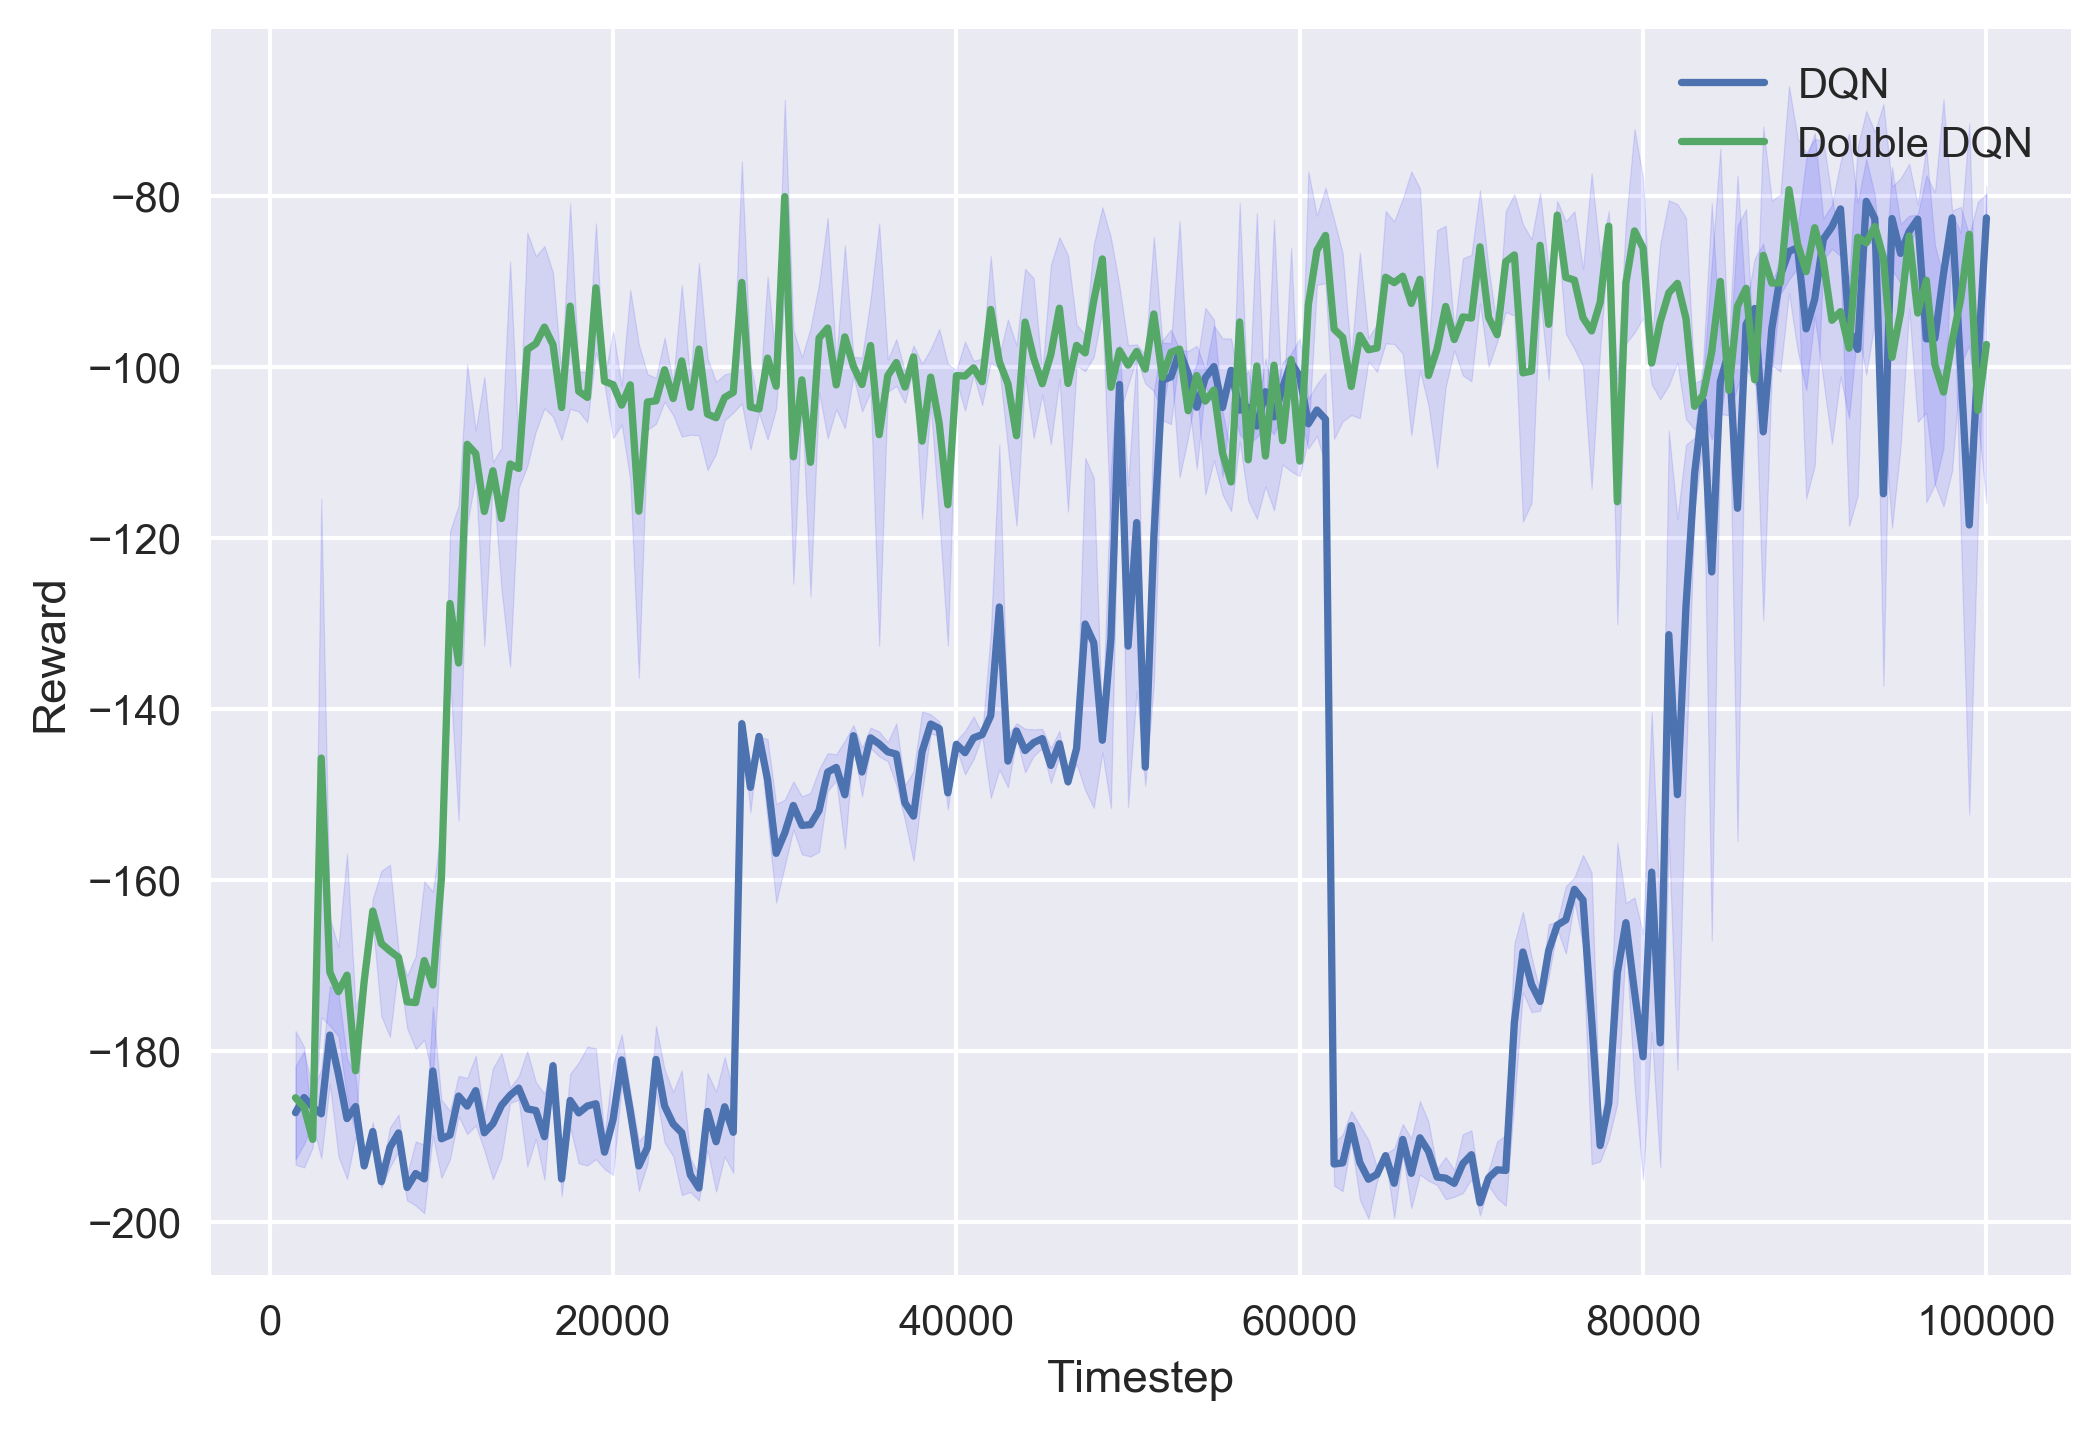

In [100]:
plt.figure(dpi=300)
df = pd.read_csv(str(log_root / "MountainCar-v0_single" / "logs_dqn.csv"), sep=";")
df_double = pd.read_csv(str(log_root / "MountainCar-v0" / "logs_dqn.csv"), sep=";")
plot_progress(df, "DQN")
plot_progress(df_double, "Double DQN")

### Look at the graphs of estimated Q values by DQN and Double DQN. Could you describe what's happening?

In [ ]:
plt.figure(dpi=300)
plt.xlabel("Timestep")
plt.ylabel("estimated Q value")
plt.plot(df['misc/timestep'], df['misc/q_est'], label="DQN")
plt.plot(df_double['misc/timestep'], df_double['misc/q_est'], label="Double DQN")
plt.legend(loc="best");

# ATARI [Optional]

In this section, you can try the algorithm on the larger problem from Atari suit. This section is optional. The training procedure is computationally cumbersome, so that ideally one may want to use GPU and powerful CPU for this task. Also note, that usually people choose larger `buffer_size` for this benchmark, which may consume anormous amount of RAM. To avoid the memory overflow, you may consider to use lossless compression algorithm to save a lot of space by compressing observations. See RLLib or Catalyst.RL for example.

If you decided to go through the task, note, that typical choice of hyperparameters for Atari differs from previous ones. See RLLib's configs, for example, as a reference.

In [ ]:
!pip install 'gym[atari]'

#### Clone and install `baselines` lib. We'll use atari wrappers from it.

Here are commands for that:
```bash
git clone https://github.com/openai/baselines
cd baselines
pip install -e .
```

In [ ]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
from lib.utils import TransposeImage

In [ ]:
def make_env(name, seed=None, monitor=False):
    env = gym.make(name)

    is_atari = hasattr(gym.envs, 'atari') and isinstance(
        env.unwrapped, gym.envs.atari.atari_env.AtariEnv)

    if is_atari:
        max_epi_steps = 108000
        if max_epi_steps < 0:
            max_epi_steps = None

        env = make_atari(name, max_epi_steps)
        env = wrap_deepmind(env, True, True, True, True)
        env = TransposeImage(env, op=[2, 0, 1])
        
    if monitor:
        env = wrappers.Monitor(env, "./gym-results", force=True)
    if seed:
        env.seed(seed)


    return env

In [ ]:
env = make_env("BreakoutNoFrameskip-v4", monitor=True)
obs = env.reset()
while True:
    act = env.action_space.sample()
    if env.step(act)[2]: break
env.close()

HTML(data=get_html_video_string(env.file_infix))

In [ ]:
env = make_env("BreakoutNoFrameskip-v4", SEED)

value_network = get_network("vision")(
    env.observation_space.shape[0],
    256,
    env.action_space.n)

agent = DQN(
    value_network,
    env.action_space,
    eps=...,
    eps_decay=...,
    batch_size=...,
    learning_rate=...,
    discount_factor=...,
    double=...,
)

In [ ]:
agent = train(
    agent,
    env,
    log_dir=log_root / "breakout-v4",
    prefix="_dqn",
    buffer_size=...,
    n_steps=...,
    warmup_steps=...,
    target_update_every=...,
    log_every=...,
    save_every=...,
)

In [ ]:
env = make_env("BreakoutNoFrameskip-v4", monitor=True)
obs = env.reset()
while True:
    obs = torch.FloatTensor(obs).unsqueeze(0)
    act = agent.pick_action(obs, force_greedy=True)
    obs, rew, done, info = env.step(act)
    if done: break
env.close()

HTML(data=get_html_video_string(env.file_infix))

In [ ]:
plt.figure(dpi=300)
df = pd.read_csv(str(log_root / "breakout-v4" / "logs_dqn.csv"), sep=";")
plot_progress(df)